In [1]:
import iris
import cf_units
import numpy as np
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams['mathtext.default'] = 'regular'

In [2]:
# Read data
path_to_gfed = Path('../../external_data/GFED')
path_to_ukca = Path('../data')
gfed = iris.load(str(path_to_gfed / 'GFED4.1s_1997-2016_multiyear_monthly_mean_dm_emissions.nc'))
ukca = iris.load_cube(str(path_to_ukca / 'xmeka' / 'xmeka_o3.nc'))
# Path to figures
path_to_figs = Path('../../../results/rono2_biomass_burning_emissions')

In [3]:
gfed

[<iris 'Cube' of fractional contribution of agricultural waste burning to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of dry matter emissions / (kg/m2/month) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of grid cell area / (m2) (latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of savanna, grassland and shrubland fires to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of peatland fires to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of boreal forest fires to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of tropical forest fires to dry matter emissions / (1) (time: 12; latitude: 720; longitude: 1440)>,
<iris 'Cube' of fractional contribution of temperate forest fires to dry matter emissions / (1) (time: 12; latitude

In [4]:
# Extract GFED dry matter emissions, GFED grid cell area, GFED and UKCA coordinates
dm = gfed.extract_strict('dry matter emissions')
dm_fr_borf = gfed.extract_strict('fractional contribution of boreal forest fires to dry matter emissions')
dm_fr_temf = gfed.extract_strict('fractional contribution of temperate forest fires to dry matter emissions')
dm_fr_sava = gfed.extract_strict('fractional contribution of savanna, grassland and shrubland fires to dry matter emissions')
dm_fr_trof = gfed.extract_strict('fractional contribution of tropical forest fires to dry matter emissions')
gfed_grid_cell_area = gfed.extract_strict('grid cell area')
gfed_lats = dm.coord('latitude').points
gfed_lons = dm.coord('longitude').points
ukca_lats = ukca.coord('latitude').points
ukca_lons = ukca.coord('longitude').points
# Restore time units. Note: in cf_units udunits.dat unit month is defined to be exactly year/12 (so all months have the same length)
dm.coord('time').units = cf_units.Unit('month') 
dm_fr_borf.coord('time').units = cf_units.Unit('month')
dm_fr_temf.coord('time').units = cf_units.Unit('month')
dm_fr_sava.coord('time').units = cf_units.Unit('month')
dm_fr_trof.coord('time').units = cf_units.Unit('month')

From https://www.geo.vu.nl/~gwerf/GFED/GFED4/ancill/code/get_GFED4s_CO_emissions.py

```python
# calculate CO emissions as the product of DM emissions (kg DM per 
# m2 per month), the fraction the specific source contributes to 
# this (unitless), and the emission factor (g CO per kg DM burned)
CO_emissions += DM_emissions * contribution * EF_CO[source]
```

From Akagi et al. (2011) Table 1 Emission factors (g kg-1) for species emitted from different types of biomass burning. Emission factors are shown with an estimate of the natural variation in parenthesis, when available. Note that boreal and extratropical forest values are the same for C1-C3 RONO2.

| RONO2   | tropical forest       | savanna             | crop residue | pasture maintenance | boreal forest | temperate forest | extratropical forest |
|---------|-----------------------|---------------------|--------------|---------------------|---------------|------------------|----------------------|
| MeONO2  | 8.29×10−3 (1.60×10−2) | 5.1×10−4 (3.7×10−4) | -            | -                   | 2.83×10−3     | -                | 2.83×10−3            |
| EtONO2  | 5.70×10−3             | -                   | -            | -                   | 1.78×10−3     | -                | 1.78×10−3            |
| nPrONO2 | 0.0003                | -                   | -            | -                   | 3.23×10−4     | -                | 3.23×10−4            |
| iPrONO2 | 0.001                 | -                   | -            | -                   | 3.23×10−3     | -                | 3.23×10−3            |

In [32]:
# Akagi et al. (2011) emission factors [g kg]
meono2_ef_trof = iris.coords.AuxCoord(8.29*1e-3, units='g/kg', long_name='methyl nitrate tropical forest fire emission factor')
meono2_ef_sava = iris.coords.AuxCoord(5.1*1e-4, units='g/kg', long_name='methyl nitrate savanna fire emission factor')
meono2_ef_borf = iris.coords.AuxCoord(2.83*1e-3, units='g/kg', long_name='methyl nitrate boreal forest fire emission factor')
etono2_ef_trof = iris.coords.AuxCoord(5.70*1e-3, units='g/kg', long_name='ethyl nitrate tropical forest fire emission factor')
etono2_ef_borf = iris.coords.AuxCoord(1.78*1e-3, units='g/kg', long_name='ethyl nitrate boreal forest fire emission factor')
nprono2_ef_trof = iris.coords.AuxCoord(0.0003, units='g/kg', long_name='npropyl nitrate tropical forest fire emission factor')
nprono2_ef_borf = iris.coords.AuxCoord(3.23*1e-4, units='g/kg', long_name='npropyl nitrate boreal forest fire emission factor')
iprono2_ef_trof = iris.coords.AuxCoord(0.001, units='g/kg', long_name='ipropyl nitrate tropical forest fire emission factor')
iprono2_ef_borf = iris.coords.AuxCoord(3.23*1e-3, units='g/kg', long_name='ipropyl nitrate boreal forest fire emission factor')
# Calculate dry matter emissions from individual sources
dm_borf = dm*dm_fr_borf
dm_temf = dm*dm_fr_temf
dm_trof = dm*dm_fr_trof
dm_sava = dm*dm_fr_sava
# Calculate lower and upper limit of GFED RONO2 biomass burning emissions
gfed_meono2_ll = (dm_borf+dm_temf)*meono2_ef_borf + dm_trof*meono2_ef_trof + dm_sava*meono2_ef_sava
gfed_etono2_ll = (dm_borf+dm_temf)*etono2_ef_borf + dm_trof*etono2_ef_trof + dm_sava*etono2_ef_trof*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0])
gfed_nprono2_ll = (dm_borf+dm_temf)*nprono2_ef_borf + dm_trof*nprono2_ef_trof + dm_sava*nprono2_ef_trof*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0])
gfed_iprono2_ll = (dm_borf+dm_temf)*iprono2_ef_borf + dm_trof*iprono2_ef_trof + dm_sava*iprono2_ef_trof*(meono2_ef_sava.points[0]/meono2_ef_trof.points[0])
gfed_meono2_ul = (dm_borf+dm_temf)*meono2_ef_borf + (dm_trof+dm_sava)*meono2_ef_trof
gfed_etono2_ul = (dm_borf+dm_temf)*etono2_ef_borf + (dm_trof+dm_sava)*etono2_ef_trof
gfed_nprono2_ul = (dm_borf+dm_temf)*nprono2_ef_borf + (dm_trof+dm_sava)*nprono2_ef_trof
gfed_iprono2_ul = (dm_borf+dm_temf)*iprono2_ef_borf + (dm_trof+dm_sava)*iprono2_ef_trof
gfed_meono2_ll.convert_units('kg/m2/s')
gfed_etono2_ll.convert_units('kg/m2/s')
gfed_nprono2_ll.convert_units('kg/m2/s')
gfed_iprono2_ll.convert_units('kg/m2/s')
gfed_meono2_ul.convert_units('kg/m2/s')
gfed_etono2_ul.convert_units('kg/m2/s')
gfed_nprono2_ul.convert_units('kg/m2/s')
gfed_iprono2_ul.convert_units('kg/m2/s')

In [33]:
gfed_lons[0:20]

array([-179.875, -179.625, -179.375, -179.125, -178.875, -178.625,
       -178.375, -178.125, -177.875, -177.625, -177.375, -177.125,
       -176.875, -176.625, -176.375, -176.125, -175.875, -175.625,
       -175.375, -175.125], dtype=float32)

In [34]:
ukca_lons[0:20]

array([ 0.  ,  3.75,  7.5 , 11.25, 15.  , 18.75, 22.5 , 26.25, 30.  ,
       33.75, 37.5 , 41.25, 45.  , 48.75, 52.5 , 56.25, 60.  , 63.75,
       67.5 , 71.25], dtype=float32)

In [35]:
def roll_cube_w2e(cube_in, inplace=False):
    """Take a cube which longitudes span -180...180 and roll them by 180 degrees west to east to 0...360.
    Inspired by https://gist.github.com/dennissergeev/0e362a8a8a8f12b87221c1519b9903cf"""
    if inplace:
        cube = cube_in
    else:
        cube = cube_in.copy()
    lon = cube.coord('longitude')
    if (lon.points < 0.).any():
        add = 180
        cube.data = np.roll(cube.data, len(lon.points) // 2, axis=-1)
        if lon.has_bounds():
            bounds = lon.bounds + add
        else:
            bounds = None
        cube.replace_coord(lon.copy(points=lon.points + add, bounds=bounds))
    if not inplace:
        return cube

In [36]:
# Roll GFED data west to east and regrid it onto UKCA grid
ukca_grid = [('longitude', ukca.coord('longitude').points), ('latitude', ukca.coord('latitude').points)]
ukca_meono2_ll = roll_cube_w2e(gfed_meono2_ll).interpolate(ukca_grid, iris.analysis.Linear())
ukca_etono2_ll = roll_cube_w2e(gfed_etono2_ll).interpolate(ukca_grid, iris.analysis.Linear())
ukca_nprono2_ll = roll_cube_w2e(gfed_nprono2_ll).interpolate(ukca_grid, iris.analysis.Linear())
ukca_iprono2_ll = roll_cube_w2e(gfed_iprono2_ll).interpolate(ukca_grid, iris.analysis.Linear())
ukca_meono2_ul = roll_cube_w2e(gfed_meono2_ul).interpolate(ukca_grid, iris.analysis.Linear())
ukca_etono2_ul = roll_cube_w2e(gfed_etono2_ul).interpolate(ukca_grid, iris.analysis.Linear())
ukca_nprono2_ul = roll_cube_w2e(gfed_nprono2_ul).interpolate(ukca_grid, iris.analysis.Linear())
ukca_iprono2_ul = roll_cube_w2e(gfed_iprono2_ul).interpolate(ukca_grid, iris.analysis.Linear())

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


### Check land mask

In [37]:
# Read UM orography data
ukca_orog = iris.util.squeeze(iris.load_cube(str(path_to_ukca / 'um_orography_xnvtj.nc'), 'OROGRAPHY (/STRAT LOWER BC)'))

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'surface' invalid units 'level'
  warnings.warn(msg)


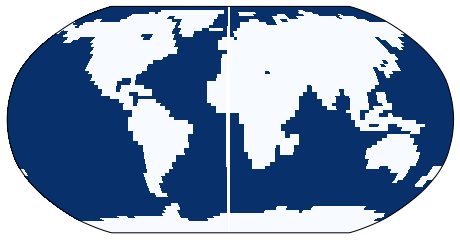

In [38]:
# Mask UKCA heights that are equal to zero
ukca_orog_masked = np.ma.masked_where(ukca_orog.data == 0., ukca_orog.data)
ukca_ocean_mask = ukca_orog_masked.mask # ocean is True
# Plot ocean mask
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
ax.pcolormesh(ukca_lons, ukca_lats, ukca_ocean_mask, transform=ccrs.PlateCarree(), cmap='Blues');

In [39]:
ukca_meono2_ll.data.min()

-4.596230964546153e-15

In [40]:
# Remove negative values and apply UKCA land mask
ukca_ocean_mask_brdcst = np.broadcast_to(ukca_ocean_mask, (12, 73, 96))
ukca_meono2_ll_corrd = np.ma.masked_where((ukca_meono2_ll.data<=0.) & ukca_ocean_mask_brdcst, ukca_meono2_ll.data).filled(fill_value=0.)
ukca_etono2_ll_corrd = np.ma.masked_where((ukca_etono2_ll.data<=0.) & ukca_ocean_mask_brdcst, ukca_etono2_ll.data).filled(fill_value=0.)
ukca_nprono2_ll_corrd = np.ma.masked_where((ukca_nprono2_ll.data<=0.) & ukca_ocean_mask_brdcst, ukca_nprono2_ll.data).filled(fill_value=0.)
ukca_iprono2_ll_corrd = np.ma.masked_where((ukca_iprono2_ll.data<=0.) & ukca_ocean_mask_brdcst, ukca_iprono2_ll.data).filled(fill_value=0.)
ukca_meono2_ul_corrd = np.ma.masked_where((ukca_meono2_ul.data<=0.) & ukca_ocean_mask_brdcst, ukca_meono2_ul.data).filled(fill_value=0.)
ukca_etono2_ul_corrd = np.ma.masked_where((ukca_etono2_ul.data<=0.) & ukca_ocean_mask_brdcst, ukca_etono2_ul.data).filled(fill_value=0.)
ukca_nprono2_ul_corrd = np.ma.masked_where((ukca_nprono2_ul.data<=0.) & ukca_ocean_mask_brdcst, ukca_nprono2_ul.data).filled(fill_value=0.)
ukca_iprono2_ul_corrd = np.ma.masked_where((ukca_iprono2_ul.data<=0.) & ukca_ocean_mask_brdcst, ukca_iprono2_ul.data).filled(fill_value=0.)

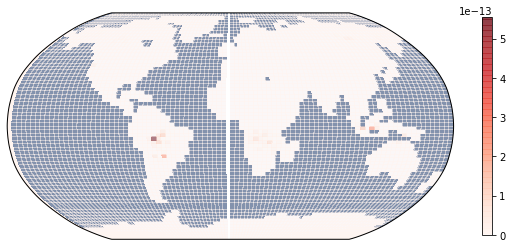

In [41]:
# Overlay UKCA land mask with emissions
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
ax.pcolormesh(ukca_lons, ukca_lats, ukca_ocean_mask, transform=ccrs.PlateCarree(), cmap='Blues')
p1 = ax.pcolormesh(ukca_lons, ukca_lats, ukca_meono2_ll_corrd[7,...], transform=ccrs.PlateCarree(), cmap='Reds', alpha=0.5);
fig.colorbar(p1, shrink=0.4);

Looks correct.

In [42]:
# Replace unmasked data in a cube with masked data
ukca_meono2_ll.data = ukca_meono2_ll_corrd
ukca_etono2_ll.data = ukca_etono2_ll_corrd
ukca_nprono2_ll.data = ukca_nprono2_ll_corrd
ukca_iprono2_ll.data = ukca_iprono2_ll_corrd
ukca_meono2_ul.data = ukca_meono2_ul_corrd
ukca_etono2_ul.data = ukca_etono2_ul_corrd
ukca_nprono2_ul.data = ukca_nprono2_ul_corrd
ukca_iprono2_ul.data = ukca_iprono2_ul_corrd

### Plot maps

In [43]:
def plt_map(lons, lats, cb, specie_latex, specie_str, source):
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)))
    p0 = ax.pcolormesh(lons, lats, cb, transform=ccrs.PlateCarree(), cmap='Reds')
    ax.coastlines(color='grey', alpha=0.2)
    ax.set_title(f'{source.upper()}\n{specie_latex} biomass burning emissions')
    fig.colorbar(p0, shrink=0.4, label='kg $m^{-2}$ $yr^{-1}$')
    fig.savefig(path_to_figs / f'{source}_rono2_{specie_str}_biomass_burning_emissions_per_yr.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


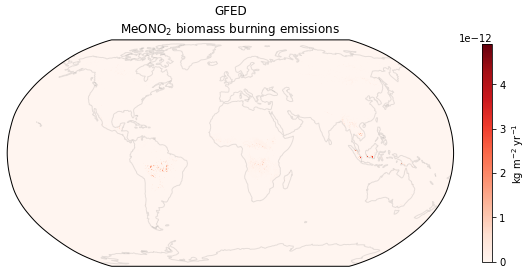

In [44]:
plt_map(gfed_lons, gfed_lats, gfed_meono2_ll.collapsed('time', iris.analysis.SUM).data, '$MeONO_2$', 'c1', 'gfed')

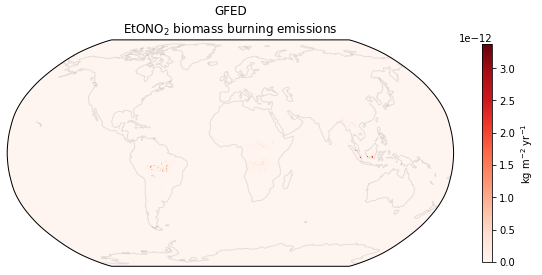

In [45]:
plt_map(gfed_lons, gfed_lats, gfed_etono2_ll.collapsed('time', iris.analysis.SUM).data, '$EtONO_2$', 'c2', 'gfed')

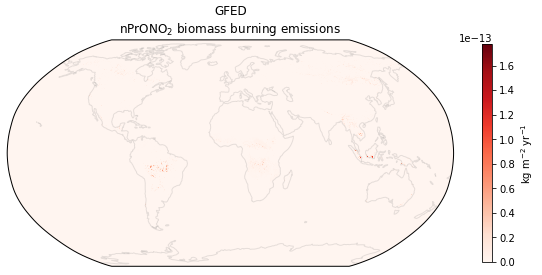

In [46]:
plt_map(gfed_lons, gfed_lats, gfed_nprono2_ll.collapsed('time', iris.analysis.SUM).data, '$nPrONO_2$', 'c3n', 'gfed')

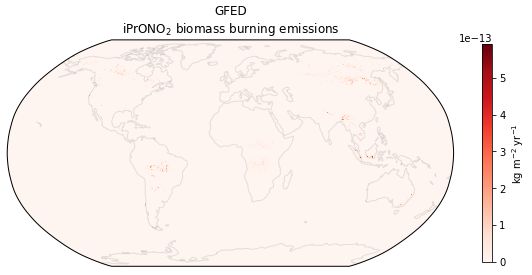

In [47]:
plt_map(gfed_lons, gfed_lats, gfed_iprono2_ll.collapsed('time', iris.analysis.SUM).data, '$iPrONO_2$', 'c3i', 'gfed')

In [48]:
ukca_meono2_ll_cyc, ukca_lons_cyc = cartopy.util.add_cyclic_point(ukca_meono2_ll.collapsed('time', iris.analysis.SUM).data, 
                                                                  coord=ukca_meono2_ll.coord('longitude').points)
ukca_etono2_ll_cyc = cartopy.util.add_cyclic_point(ukca_etono2_ll.collapsed('time', iris.analysis.SUM).data)
ukca_nprono2_ll_cyc = cartopy.util.add_cyclic_point(ukca_nprono2_ll.collapsed('time', iris.analysis.SUM).data)
ukca_iprono2_ll_cyc = cartopy.util.add_cyclic_point(ukca_iprono2_ll.collapsed('time', iris.analysis.SUM).data)

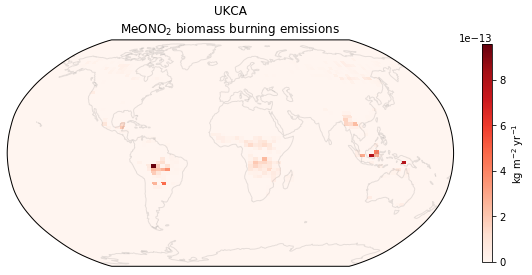

In [49]:
plt_map(ukca_lons_cyc, ukca_lats, ukca_meono2_ll_cyc.data, '$MeONO_2$', 'c1', 'ukca')

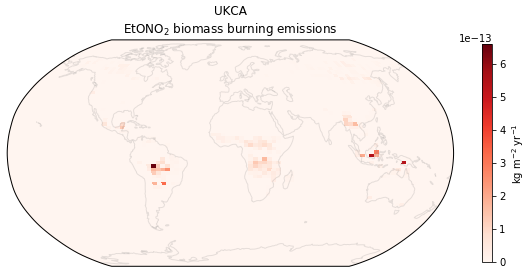

In [50]:
plt_map(ukca_lons_cyc, ukca_lats, ukca_etono2_ll_cyc.data, '$EtONO_2$', 'c2', 'ukca')

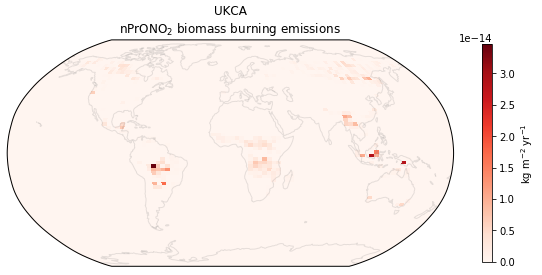

In [51]:
plt_map(ukca_lons_cyc, ukca_lats, ukca_nprono2_ll_cyc.data, '$nPrONO_2$', 'c3n', 'ukca')

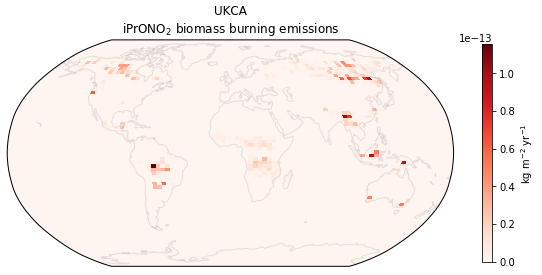

In [52]:
plt_map(ukca_lons_cyc, ukca_lats, ukca_iprono2_ll_cyc.data, '$iPrONO_2$', 'c3i', 'ukca')

### Calculate and compare burdens

In [53]:
gfed_cb_list = [gfed_meono2_ll, gfed_etono2_ll, gfed_nprono2_ll, gfed_iprono2_ll, gfed_meono2_ul, gfed_etono2_ul, gfed_nprono2_ul, gfed_iprono2_ul,
               gfed_grid_cell_area]
for cb in gfed_cb_list:
    for coord in ['latitude', 'longitude']:
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
    cb.coord('latitude').units = 'degrees'
    cb.coord('longitude').units = 'degrees'
def calc_burden_gfed(cb):
    # Calculate emission per grid cell per year
    cb_per_yr = cb.collapsed('time', iris.analysis.SUM)
    # Find area sum per year and multiply it by grid cell area
    cb_per_yr_area_sum = cb_per_yr*gfed_grid_cell_area
    # Calculate burden
    cb_burden = cb_per_yr_area_sum.collapsed(['latitude', 'longitude'], iris.analysis.SUM)
    cb_burden.convert_units('Gg/yr')
    return f'{cb_burden.data:1.2f}, Gg/yr;'

In [54]:
ukca_cb_list = [ukca_meono2_ll, ukca_etono2_ll, ukca_nprono2_ll, ukca_iprono2_ll, ukca_meono2_ul, ukca_etono2_ul, ukca_nprono2_ul, ukca_iprono2_ul]
for cb in ukca_cb_list:
    for coord in ['latitude', 'longitude']:
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
        if not cb.coord(coord).has_bounds():
            cb.coord(coord).guess_bounds()
    cb.coord('latitude').units = 'degrees'
    cb.coord('longitude').units = 'degrees'
def calc_burden_ukca(cb):
    # Calculate emission per grid cell per year
    cb_per_yr = cb.collapsed('time', iris.analysis.SUM)
    # Calculate area weights and Earth's area
    area_weights_norm = iris.analysis.cartography.area_weights(cb_per_yr, normalize=True)
    area_weights_inm2 = iris.analysis.cartography.area_weights(cb_per_yr, normalize=False)
    earth_area = iris.cube.Cube(area_weights_inm2.sum(), units='m2')
    # Calculate burden: find area sum per year and multiply it by Earth's area
    cb_per_yr_area_sum = cb_per_yr.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=area_weights_norm)
    cb_burden = cb_per_yr_area_sum*earth_area
    cb_burden.convert_units('Gg/yr')
    return f'{cb_burden.data:1.2f}, Gg/yr;', cb_burden.data

In [55]:
print(calc_burden_gfed(gfed_meono2_ll), calc_burden_gfed(gfed_etono2_ll), calc_burden_gfed(gfed_nprono2_ll), calc_burden_gfed(gfed_iprono2_ll))
print(calc_burden_gfed(gfed_meono2_ul), calc_burden_gfed(gfed_etono2_ul), calc_burden_gfed(gfed_nprono2_ul), calc_burden_gfed(gfed_iprono2_ul))

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


52.36, Gg/yr; 35.69, Gg/yr; 2.31, Gg/yr; 11.78, Gg/yr;
319.90, Gg/yr; 219.64, Gg/yr; 11.99, Gg/yr; 44.05, Gg/yr;


In [56]:
print(calc_burden_ukca(ukca_meono2_ll)[0], calc_burden_ukca(ukca_etono2_ll)[0], calc_burden_ukca(ukca_nprono2_ll)[0], calc_burden_ukca(ukca_iprono2_ll)[0])
print(calc_burden_ukca(ukca_meono2_ul)[0], calc_burden_ukca(ukca_etono2_ul)[0], calc_burden_ukca(ukca_nprono2_ul)[0], calc_burden_ukca(ukca_iprono2_ul)[0])

53.69, Gg/yr; 36.60, Gg/yr; 2.36, Gg/yr; 11.89, Gg/yr;
327.31, Gg/yr; 224.74, Gg/yr; 12.26, Gg/yr; 44.90, Gg/yr;


/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [57]:
rono2_burden_ll_ukca = calc_burden_ukca(ukca_meono2_ll)[1]+calc_burden_ukca(ukca_etono2_ll)[1]+ \
                       calc_burden_ukca(ukca_nprono2_ll)[1]+calc_burden_ukca(ukca_iprono2_ll)[1]
rono2_burden_ul_ukca = calc_burden_ukca(ukca_meono2_ul)[1]+calc_burden_ukca(ukca_etono2_ul)[1]+ \
                       calc_burden_ukca(ukca_nprono2_ul)[1]+calc_burden_ukca(ukca_iprono2_ul)[1]
print(f'{rono2_burden_ll_ukca:1.2f}, Gg/yr')
print(f'{rono2_burden_ul_ukca:1.2f}, Gg/yr')

104.54, Gg/yr
609.20, Gg/yr


In [58]:
104.54/18

5.807777777777778

From Simpson et al. (2002):

'...global savanna burning emissions for the five C1–C4 alkyl nitrates reported here are estimated to total roughly 6.6 Gg/yr (mainly as MeONO2) during the flaming stage, and 1.2 Gg/yr (mainly as C2–C4 alkyl nitrates) during the smoldering stage, for a total on the order of 8 Gg/yr (Table 3). For global biomass burning, summed C1–C4 alkyl nitrate emissions on the order of 18 Gg/yr are estimated. In both cases, MeONO2 emissions during the flaming stage comprise a majority (roughly two-thirds) of the total C1–C4 alkyl nitrate emissions'.

So, the upper limit of the sum of C1-C3 RONO2 biomass burning emissions from GFED is 30 times higher than Simpson et al. estimate. Lower limit GFED estimate Thus we are going to use the low limit GFED estimate as it is of same order of magnitude as Simpson et al. value, although it's 5.8 times highe. 

### Create perpetual year emissions

In [ ]:
# Repeat emissions data 10 times along time axis
perpetual_meono2_arr = np.moveaxis(np.tile(np.moveaxis(ukca_meono2_ll.data, 0, -1), 10), -1, 0)
perpetual_etono2_arr = np.moveaxis(np.tile(np.moveaxis(ukca_etono2_ll.data, 0, -1), 10), -1, 0)
perpetual_nprono2_arr = np.moveaxis(np.tile(np.moveaxis(ukca_nprono2_ll.data, 0, -1), 10), -1, 0)
perpetual_iprono2_arr = np.moveaxis(np.tile(np.moveaxis(ukca_iprono2_ll.data, 0, -1), 10), -1, 0)
# Create a new time dimention or copy ukca.coord('time') if shapes are the same
if perpetual_meono2_arr.shape == ukca.coord('time').shape:
    time = ukca.coord('time')
else:
    start_date = ukca.coord('time').points[0]
    hours_since_start_date = np.arange(start_date, start_date+10*12*30*24, 720) # montly intervals in hours using 360 day calendar
    time = iris.coords.DimCoord(hours_since_start_date, standard_name='time', var_name='time', units=ukca.coord('time').units)

In [ ]:
# Create iris cubes
perpetual_meono2_cb = iris.cube.Cube(perpetual_meono2_arr, long_name='methyl_nitrate_biomass_burning_emission', units='kg/m2/s',
                                     dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_etono2_cb = iris.cube.Cube(perpetual_etono2_arr, long_name='ethyl_nitrate_biomass_burning_emission', units='kg/m2/s',
                                     dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_nprono2_cb = iris.cube.Cube(perpetual_nprono2_arr, long_name='npropyl_nitrate_biomass_burning_emission', units='kg/m2/s',
                                      dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])
perpetual_iprono2_cb = iris.cube.Cube(perpetual_iprono2_arr, long_name='ipropyl_nitrate_biomass_burning_emission', units='kg/m2/s',
                                      dim_coords_and_dims=[(time, 0), (ukca.coord('latitude'), 1), (ukca.coord('longitude'), 2)])

In [ ]:
# Save iris cubes to .nc
iris.save(perpetual_meono2_cb, str(path_to_ukca / 'perpetual_meono2_biomass_burning_emissions.nc'))
iris.save(perpetual_etono2_cb, str(path_to_ukca / 'perpetual_etono2_biomass_burning_emissions.nc'))
iris.save(perpetual_nprono2_cb, str(path_to_ukca / 'perpetual_nprono2_biomass_burning_emissions.nc'))
iris.save(perpetual_iprono2_cb, str(path_to_ukca / 'perpetual_iprono2_biomass_burning_emissions.nc'))